In [7]:
# %%
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np

# %%
data = pd.read_csv('data/alldata.csv', sep = ',')

# %% Selecionar principais variaveis:
    
#Crosstable
    
crosstable = pd.read_csv('data/CrosstableVariables.csv', sep = ';')
crosstable.drop(crosstable.columns[[0,4,5,6,7,8,9,10]], axis = 1, inplace =  True)

#Apenas dor na lombar
crosstable = crosstable.loc[crosstable['denominador']=='D30']

#Filtro da frequência
crosstable = crosstable.loc[crosstable['Frequência']>0.6]

crossnames = list(crosstable.numerador)

# Bisserial
biserial = pd.read_csv('data/biseralmaincorrelations.csv', sep = ',')
biserial.drop(biserial.columns[[3,4,5,6]], axis = 1, inplace = True)

#Apenas dor na lombar
biserial = biserial.loc[biserial['Binaria']=='Lombalgia']

#Filtro do coeficiente de correlação de ponto bisserial
biserial = biserial.loc[(biserial['rpb'] > 0.5) | (biserial['rpb'] < -0.5)]

biserialnames = list(biserial.Ordinal)
#Final

biserialandcross = crossnames + biserialnames

data = data[biserialandcross]

#Retornar apenas as linhas que possuem resultado em D30

data = data[data.D30.notnull()]
data.drop('Há quanto tempo em São Paulo se de outro local', axis = 1, inplace = True)

#Retornar apenas as linhas que possuem menos de 10 % de valores nulos
nulldataframe = pd.DataFrame(data.isnull().sum())
miss = nulldataframe/data.shape[0]

miss.columns = ['Valor']

miss = miss[miss['Valor'] < 0.15]

listanaonulos = list(miss.index)

data = data[listanaonulos]
# %% Imputar valores nulos
from sklearn.impute import SimpleImputer

imp = SimpleImputer(missing_values = np.nan, strategy = 'median')

imp.fit(data)

data_nonan = pd.DataFrame(imp.transform(data), columns = list(data))

data_nonan.isnull().sum().sum()

#Testando só com binários:
data_pca = data_nonan

# %% Normalização dos ordinais

data_bin = data_pca.iloc[:,np.r_[0:7]]
data_ord = data_pca.iloc[:,np.r_[7:10]]

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

ss.fit(data_ord)

data_ord_ss = pd.DataFrame(ss.transform(data_ord), columns = list(data_ord))

data_pca = pd.concat([data_bin,data_ord_ss], axis = 1)


# %% Divisao entre treino e teste
df = data_pca

X = df.drop('D30', axis = 1)
#pca_model = PCA(n_components = 10)
#pca_model.fit(X)
#X_pca = pca_model.transform(X)
X_pca = X

y = df['D30']

In [19]:
y.shape

(136,)

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_pca,y, test_size = 0.3)

In [22]:
y_test.shape

(41,)

# Regressão Logística

In [14]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train,y_train)

LogisticRegression()

In [15]:
THRESHOLD = 0.45
previsoes = np.where(lr.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

In [16]:
from sklearn.metrics import confusion_matrix, accuracy_score

acuracia = accuracy_score(y_test, previsoes); acuracia
matriz = confusion_matrix(y_test, previsoes); matriz

array([[15,  2],
       [ 7, 17]])

In [18]:
y_test.shape

(41,)

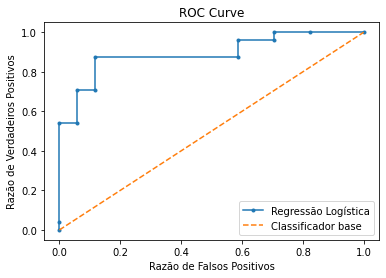

In [17]:
# %%ROC Curve

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def roccurve(y_test, probs, modelname):
    # Gerar os dados da diagonal (no skill classifier)
    ns_probs = [0 for item in range(len(y_test))]
    ns_fpr, ns_tpr, ns_thres = roc_curve(y_test, ns_probs)
    
    #Probabilidades da classe positiva
    fpr, tpr, thresholds = roc_curve(y_test, probs[:,1])
    auc = roc_auc_score(y_test, probs[:,1])
    
    plt.plot(fpr, tpr, marker = '.', label = modelname)
    plt.plot(ns_fpr, ns_tpr, linestyle = '--', label = 'Classificador base')
    plt.xlabel('Razão de Falsos Positivos')
    plt.ylabel('Razão de Verdadeiros Positivos')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# %% APlicação da função roc curve parao modelo de regressão logística
probs = lr.predict_proba(X_test)

roccurve(y_test, probs, 'Regressão Logística')

In [23]:
probs.shape

(41, 2)

In [ ]:
# %% Precision Recall Curve 



def precisionrecall(y_test, probs, modelname):

  from sklearn.metrics import precision_recall_curve
    
    precision, recall, thresholds = precision_recall_curve(y_test, probs[:,1])
    
    no_skill = len(y_test[y_test ==1]) / len(y_test)
    
    plt.plot([0,1], [no_skill, no_skill], linestyle = '--', label = 'Classificador base')
    plt.plot(precision, recall, marker = '.', label =  modelname)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

# %% Aplicação da Precision Recall para Regressão Logística    
probs = lr.predict_proba(X_test)
modelname = 'Regressão Logística'

precisionrecall(y_test, probs, modelname)

# %% Com validação cruzada:

In [ ]:
probs

In [1]:
    
from sklearn.model_selection import cross_validate

def cvfunction(model):
    acuracia = cross_validate(model, X, y, cv = 10, 
                              scoring = ['accuracy','f1','recall','precision'],
                              return_train_score = True)
    
    f1 = acuracia['test_f1'].mean()
    precision = acuracia['test_precision'].mean()
    recall = acuracia['test_recall'].mean()
    acuracia = acuracia['test_accuracy'].mean()
    
    cvresults = pd.DataFrame({'acuracia':[acuracia],
                              'precisao':[precision],
                              'recall':[recall],
                              'f1':[f1]})
    
    return cvresults
# %% Criação da lista que receberá o resultado das métricas de todos os modelos

restable = [[0]*4]*5
type(restable)

# %% Atribuição do resultado das métricas do modelo de Regressão Logística
cvresults = cvfunction(lr)
cvresults

IndentationError: unexpected indent (<ipython-input-1-33832257ac59>, line 236)